In [9]:
# 同时计算mua和mus,只输入波峰信息
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
import math
from tensorflow import keras
import sklearn
# from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import keras_tuner

In [2]:
with open("C:\\Users\\Administrator\\source\\data\\dataset_test.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [3]:
with open("C:\\Users\\Administrator\\source\\data\\dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

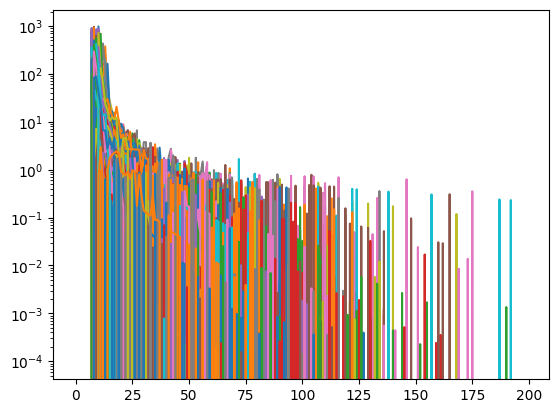

1262
[1.24224685e-02 9.14926987e+01 1.54261023e+03 8.50000024e-01]


In [56]:
plt.axes(yscale = "log") 
for n in range(sig1.shape[0]):
    plt.plot(sig1[n])
plt.show()
print(NM1)
print(an2[-1])

In [5]:

# def labeling(y,N):
#     ##############
#     a,b = y.shape
#     min0 = np.min(y,0)
#     max0 = np.max(y,0)
#     step = (max0-min0)/N
#     y2 = np.zeros((a,b,N))
    
#     # kernel = np.array([1]) 
#     # kernel = kernel/np.sum(kernel)
    
#     for i in range(a):
#         for j in range(b):
#             if(step[j]!=0):
#                 idx = (y[i,j]-min0[j])/step[j]-1
#                 y2[i,j,int(idx)] = 1
#             else:
#                 y2[i,j,0] = 1
#             # y2[i,j] = np.convolve(y2[i,j],kernel,mode='same')
            
#     return y2    
  

In [83]:
xsig = sig1[0]
peaks, _ = find_peaks(xsig, height=0)
plt.plot(xsig)
plt.plot(peaks, xsig[peaks], "x")
plt.plot(np.zeros_like(xsig), "--", color="gray")
plt.show()

x = np.zeros((peaks.shape[0]+2,))
y = np.zeros((peaks.shape[0]+2,))
x[1:-1] = peaks
y[1:-1] = xsig[peaks]
x[-1] = sig1.shape[1]
plt.plot(x,y)
plt.show()

f2 = interp1d(x, y, kind='linear')
N = 200
xnew = np.linspace(0, N,num=N)
ynew = f2(xnew)

# plt.axes(yscale = "log") 
plt.plot(ynew)
plt.show()

In [4]:
def smooth_peak(xsig):
    peaks, _ = find_peaks(xsig, height=0)
    # plt.plot(xsig)
    # plt.plot(peaks, xsig[peaks], "x")
    # plt.plot(np.zeros_like(xsig), "--", color="gray")
    # plt.show()
    if(peaks.shape[0]!=0):
        x = np.zeros((peaks.shape[0]+3,))
        y = np.zeros((peaks.shape[0]+3,))
        x[1:-2] = peaks
        y[1:-2] = xsig[peaks]
        x[-1] = sig1.shape[1]
        y[-1] = 0
        x[-2] = peaks[-1]+5
        y[-2] = 0
        # plt.plot(x,y)
        # plt.show()

        f2 = interp1d(x, y, kind='linear')
        N = xsig.shape[0]
        xnew = np.linspace(0, N,num=N)
        ynew = f2(xnew)
    
    else:
        ynew = np.zeros((xsig.shape[0],))

    return ynew
#     # plt.axes(yscale = "log") 
#     plt.plot(ynew)
#     plt.show()
    

In [5]:
msig1 = np.zeros((sig1.shape[0],sig1.shape[1]))
an3 = np.zeros((an1.shape))
i_invalid = 0
flag = 0
for i in range(sig1.shape[0]):
    ynew = smooth_peak(sig1[i])
    if(np.all(ynew == 0)):
        i_invalid = i_invalid+1
    else:
        msig1[flag] = ynew
        an3[flag] = an1[i]
        flag = flag+1
msig1 = msig1[0:msig1.shape[0]-i_invalid,:]  
an3 = an3[0:an3.shape[0]-i_invalid,:]

i_invalid = 0
flag = 0
msig2 = np.zeros((sig2.shape[0],sig2.shape[1]))
an4 = np.zeros((an2.shape))
for i in range(sig2.shape[0]):
    ynew = smooth_peak(sig2[i])
    if(np.all(ynew == 0)):
        i_invalid = i_invalid+1
    
    else:
        msig2[flag] = ynew
        an4[flag] = an2[i]
        flag = flag+1
msig2 = msig2[0:msig2.shape[0]-i_invalid,:] 
an4 = an4[0:an4.shape[0]-i_invalid,:]

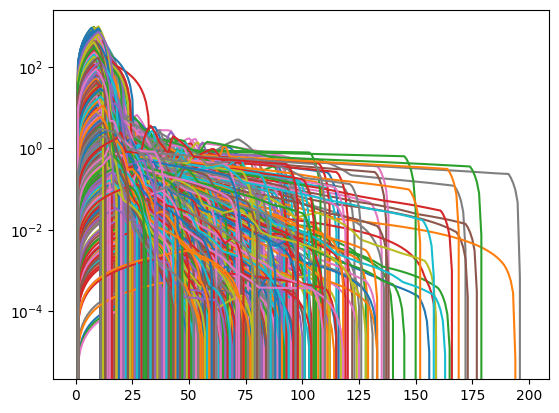

In [33]:
plt.axes(yscale = "log") 
for n in range(msig1.shape[0]): #msig1.shape[0]
    plt.plot(msig1[n])
plt.show()

In [6]:
# x_train = msig1
y_train = an3
# x_test = msig2
y_test = an4

x_train = np.zeros((msig1.shape[0],3))
x_test = np.zeros((msig2.shape[0],3))

x_train[:,0] = np.argmax(msig1,1)/200*3
x_train[:,1] = np.diagonal(msig1[:,np.argmax(msig1,1)])/1000 # t of peak, height of peak, thickness(d)
x_train[:,2] = an3[:,0]/20e-3 
# x_train = np.log10(x_train)+7

x_test[:,0] = np.argmax(msig2,1)/200*3
x_test[:,1] = np.diagonal(msig2[:,np.argmax(msig2,1)])/1000 
x_test[:,2] = an4[:,0]/20e-3
# x_test = np.log10(x_test)+7

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
# d_train = np.reshape(y_train[:,0],(y_train[:,0].shape[0],1,1)) # add thickness of sample into input data
# d_test = np.reshape(y_test[:,0],(y_test[:,0].shape[0],1,1))

# x_train = np.concatenate((d_train,x_train),axis = 1) 
# x_test = np.concatenate((d_test,x_test),axis = 1)
y_train[:,1] = y_train[:,1]/1e2
y_test[:,1] = y_test[:,1]/1e2
y_train[:,2] = y_train[:,2]/200e2
y_test[:,2] = y_test[:,2]/200e2
y_train = y_train[:,1:3]
y_test = y_test[:,1:3]
# y_train = labeling(y_train,num_labels)[:,1,:] # select to predict what : 0:thickness 1:mua 2: mus
# y_test = labeling(y_test,num_labels)[:,1,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 

x_train.shape = (1258, 3, 1)
y_train.shape = (1258, 2)


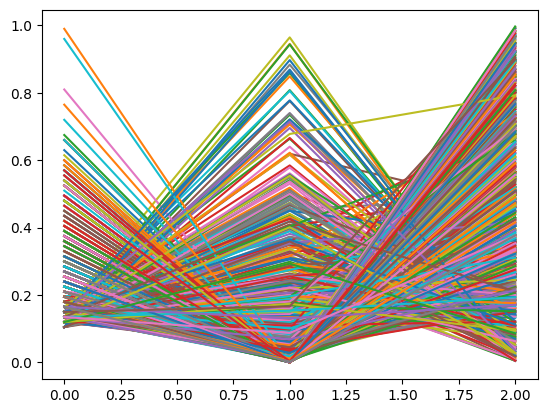

In [7]:
for n in range(x_train.shape[0]):  #x_train.shape[0]
    plt.plot(x_train[n,:])
plt.show()


In [8]:
# num_classes = y_train.shape[1]
########################################
# input_shape = (1,5,1)
# x = np.arange(np.prod(input_shape)).reshape(input_shape)      # test cropping#
# print(x)
# y = keras.layers.Cropping1D(cropping=(0,4))(x)
# z = keras.layers.Cropping1D(cropping=(1,0))(x)
# print(y)
# print(z)

In [82]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
#     d_1 = keras.layers.Cropping1D(cropping=(0,2))(input_layer)
#     sig = keras.layers.Cropping1D(cropping=(1,0))(input_layer)
    
#     conv1 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same")(sig)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

    # gap = keras.layers.GlobalAveragePooling1D()(conv3)
    gap = keras.layers.Reshape((input_shape[0],))(input_layer)
    
    gap = keras.layers.Dense(64, kernel_initializer='normal',activation='relu')(gap)
    gap = keras.layers.Dense(64, kernel_initializer='normal',activation='relu')(gap)
    gap = keras.layers.Dense(64, kernel_initializer='normal',activation='relu')(gap)
    # gap = keras.layers.BatchNormalization()(gap)
    # gap = keras.layers.Dropout(0.5)(gap)
    gap = keras.layers.Dense(64, kernel_initializer='normal',activation='relu')(gap)
    gap = keras.layers.Dense(64, kernel_initializer='normal',activation='relu')(gap)
    gap = keras.layers.Dense(64, kernel_initializer='normal',activation='relu')(gap)
    # gap = keras.layers.BatchNormalization()(gap)
    # gap = keras.layers.Dropout(0.5)(gap)
    
    # d_1 = keras.layers.Dense(16, activation='relu')(d_1)
    # d_1 = keras.layers.Dense(16, activation='relu')(d_1)
    # gap = keras.layers.Reshape((16,))(gap)
    
    
    
    # merged = keras.layers.Concatenate()([d_1, gap])
    # merged = keras.layers.Dense(8, activation='relu')(merged)
    
    output_layer = keras.layers.Dense(2, activation="linear")(gap)  
    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [90]:
class MyHyperModel(keras_tuner.HyperModel) :
    
    # def __int__(self, input_shape):
    #     self.input_shape = input_shape
        
    def build(self, hp) :  
        input_layer = keras.layers.Input((3,1))

        d_1 = keras.layers.Reshape((3,))(input_layer)
    


        for i in range(hp.Int("num_dense_d1", min_value=1, max_value=9, step=1)):
            d_1 = keras.layers.Dense(hp.Int(name=f"dense_d1_{i}", min_value=4, max_value=64, step=2)
                                    ,kernel_initializer='normal', activation='relu')(d_1)
            # if hp.Boolean("batch_norm"): 
            #     d_1 = keras.layers.BatchNormalization()(d_1) 
            # if hp.Boolean("dropout"): 
            #     d_1 = keras.layers.Dropout(0.5)(d_1)
        
        for i in range(hp.Int("num_dense_li", min_value=1, max_value=4, step=1)):
            d_1 = keras.layers.Dense(hp.Int(name=f"dense_d1_{i}", min_value=4, max_value=16, step=2)
                                    ,kernel_initializer='normal', activation='linear')(d_1)        
      

        output_layer = keras.layers.Dense(2, activation="linear")(d_1)
        
        model = keras.models.Model(inputs=input_layer, outputs=output_layer)
        
        model.compile(
                optimizer="adam",
                # loss="mean_squared_error",
                loss="mean_squared_error",
                metrics=["MeanAbsoluteError"],
            )
        
        return model
    
    def fit(self, hp, model,x, *args, **kwargs) : 
 
        return model.fit( x,  
                         *args, 
                         shuffle=hp.Boolean("shuffle"), 
                         **kwargs)
# hp = keras_tuner.HyperParameters()
# model = MyHyperModel().build(hp,)
# keras.utils.plot_model(model, show_shapes=True)


In [34]:
tuner = keras_tuner.BayesianOptimization( 
                        hypermodel=MyHyperModel(), 
                        objective = "val_loss", 
                        max_trials =10, #max candidates to test 
                        overwrite=True, 
                        directory='BO_search_dir', 
                        project_name='sign_language_cnn')

In [91]:
tuner = keras_tuner.Hyperband(hypermodel=MyHyperModel(),
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                             overwrite=True)

In [92]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train, y_train, epochs=50, validation_split=0.4, callbacks=[stop_early])

Trial 90 Complete [00h 00m 09s]
val_loss: 0.04984452947974205

Best val_loss So Far: 0.0489463247358799
Total elapsed time: 00h 05m 24s
INFO:tensorflow:Oracle triggered exit


In [93]:
best_hps = tuner.get_best_hyperparameters(1) 
h_model = MyHyperModel() 
model = h_model.build(best_hps[0])
model.save('hp_model01.h5')

In [94]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 3)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 46)                184       
_________________________________________________________________
dense_7 (Dense)              (None, 52)                2444      
_________________________________________________________________
dense_8 (Dense)              (None, 34)                1802      
_________________________________________________________________
dense_9 (Dense)              (None, 62)                2170      
_________________________________________________________________
dense_10 (Dense)             (None, 46)                2898

In [95]:
epochs = 500
batch_size = 32
#####################################################
index = [i for i in range(x_train.shape[0])]  
np.random.shuffle(index) 
x_train = x_train[index]
y_train = y_train[index]
####################################################
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model3.5.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    # loss="mean_squared_error",
    loss="mean_absolute_error",
    metrics=["MeanAbsoluteError"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.4,
    verbose=1,
)

Epoch 1/500
24/24 [==============================] - 1s 13ms/step - loss: 0.3486 - mean_absolute_error: 0.3486 - val_loss: 0.2564 - val_mean_absolute_error: 0.2564
Epoch 2/500
24/24 [==============================] - 0s 8ms/step - loss: 0.2506 - mean_absolute_error: 0.2506 - val_loss: 0.2459 - val_mean_absolute_error: 0.2459
Epoch 3/500
24/24 [==============================] - 0s 8ms/step - loss: 0.2505 - mean_absolute_error: 0.2505 - val_loss: 0.2381 - val_mean_absolute_error: 0.2381
Epoch 4/500
24/24 [==============================] - 0s 8ms/step - loss: 0.2478 - mean_absolute_error: 0.2478 - val_loss: 0.2385 - val_mean_absolute_error: 0.2385
Epoch 5/500
24/24 [==============================] - 0s 8ms/step - loss: 0.2477 - mean_absolute_error: 0.2477 - val_loss: 0.2379 - val_mean_absolute_error: 0.2379
Epoch 6/500
24/24 [==============================] - 0s 7ms/step - loss: 0.2445 - mean_absolute_error: 0.2445 - val_loss: 0.2337 - val_mean_absolute_error: 0.2337
Epoch 7/500
24/24 [==

In [96]:
model = keras.models.load_model("best_model3.5.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test error", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 107ms/step - loss: 0.1501 - mean_absolute_error: 0.1501
Test error 0.15012362599372864
Test loss 0.15012362599372864


In [97]:
mua = np.zeros((x_train.shape[0],))
mus = np.zeros((x_train.shape[0],))
d = np.zeros((x_train.shape[0],))
miu = np.zeros((x_train.shape[0],2))

miu = model.predict(x_train)
mua = miu[:,0]
mus = miu[:,1]
d = x_train[:,0,0]

In [98]:
err = np.zeros((x_train.shape[0],2))

err[:,0] = y_train[:,0]-mua
err[:,1] = y_train[:,1]-mus
# print(mua[k],mus[k],d[k])
# print(y_train[k])

In [99]:
k=np.random.randint(0,x_train.shape[0],1)[0]
print(mua[k],mus[k],d[k])
print(y_train[k])

0.36097512 0.08095117 0.12
[0.01960609 0.14625233]


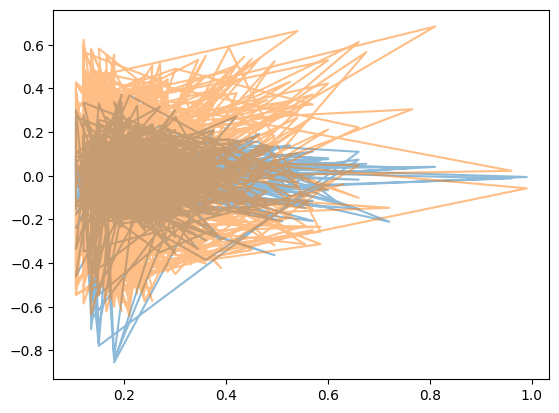

In [100]:
plt.plot(d,err[:,1],alpha=0.5)
plt.plot(d,err[:,0],alpha=0.5)
plt.show()

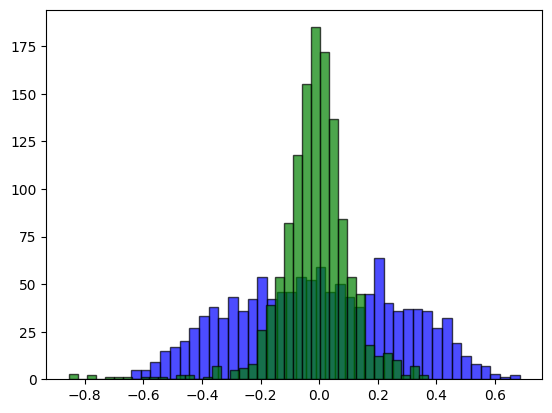

In [101]:
# print(mua,mus,d)
# print(an2[i,1],an2[i,2],an2[i,0])
# plt.plot(abs(an1[:,1]-mua))
# plt.plot(abs(an1[:,2]-mus))
plt.hist((y_train[:,0]-mua), bins=40,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist((y_train[:,1]-mus), bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
plt.show()

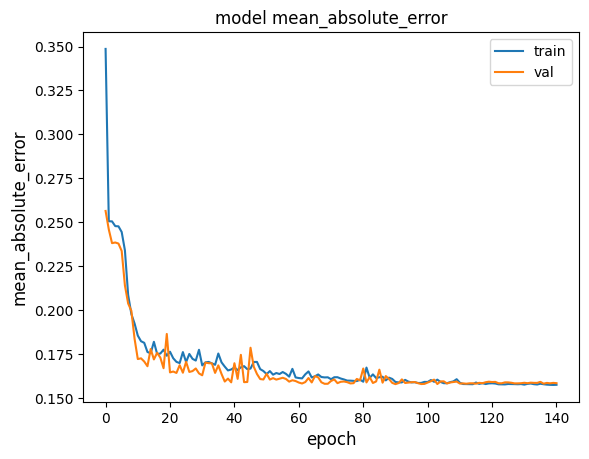

In [102]:
metric = "mean_absolute_error"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# 你可以用pca或者一些降维方法把特征搞一下